In [2]:
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages')
import requests, re
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import datetime
import talib
import math
import matplotlib.pyplot as plt
from datetime import date

In [33]:
def get_candle_df(df , frequency):
    candle_df = pd.DataFrame()
    
    candle_df['candle_high']=df.resample(frequency).apply(lambda x : x.High.max()).dropna()
    candle_df['candle_low']=df.resample(frequency).apply(lambda x : x.Low.min()).dropna()
    candle_df['candle_open'] = df.resample(frequency, convention='start').asfreq().Open
    candle_df['candle_close'] = df.resample(frequency , convention = 'end').asfreq().Close
    candle_df['rsi'] = df.resample(frequency , convention = 'end').asfreq().rsi
    
    return candle_df

In [34]:
def BBand(df, base='candle_close', period=5, multiplier=3):
 
    upper = 'BB_' + str(period) + '_' + str(multiplier)
    #lower = 'LowerBB_' + str(period) + '_' + str(multiplier)
    
    sma = df[base].rolling(window=period, min_periods=period - 1).mean()
    sd = df[base].rolling(window=period).std()
    df[upper] = sma + (multiplier * sd)
    #df[lower] = sma - (multiplier * sd)
    
    df[upper].fillna(0, inplace=True)
    #df[lower].fillna(0, inplace=True)
    
    return df

# use multiplier +1 for upper and -1 for lower

In [35]:
tickers = pd.read_csv(r'A:/finance_stuff/nifty_100/ind_nifty100list.csv')['Symbol'].to_list()

In [36]:
def df_setup(ticker):
    df=pd.read_csv(r'A:\finance_stuff\Intraday_Data\\' + str(ticker) + '.csv')
     #datetime
    rsi = talib.RSI(df.Close , timeperiod =60)
    df['rsi'] = rsi
        
    df['Time']=pd.to_datetime(df['Time'].apply(lambda x: x.split('+')[0]))
    df.set_index('Time',inplace=True)
     #candle
    candle_df = get_candle_df(df,'3T')
    #BB data
    bb_df = BBand(candle_df, period = 100 , multiplier = 0)
    bb_df = BBand(candle_df, period = 100, multiplier = 1)
    bb_df = BBand(candle_df, period = 100, multiplier = 2)
    bb_df = BBand(candle_df, period = 100, multiplier = -1)
    bb_df = BBand(candle_df, period = 100, multiplier = -2)
    
    bb_df.dropna(inplace = True)
    
    return bb_df

In [37]:
def BB_tradebook(df):
    data = df
    result = df
    
    trade_book_long={}
    trade_book_short={}
    position=0
    sl=0.0025
    tp=0.005
    p=0
    entry_price=0
    entry_price_s=0
    exit_price=0
    exit_price_s=0
   
    for i in range(101, len(data.index)):
        if ((position == 0)&(result.loc[ data.index[i-1] ,'rsi'] > 50 )
            &(result.loc[ data.index[i-1] ,'candle_high']>result.loc[data.index[i-1],'BB_100_1'])
            &(result.loc[ data.index[i-1] ,'candle_low']<result.loc[data.index[i-1],'BB_100_2'])):
            
            rsi = result.loc[ data.index[i] ,'rsi']
            position=1
            time=data.index[i]
            entry_time_l=time
            #print('position entered at {}'.format(time))
    #             x.at[i,'position']=1
            entry_price=data.loc[data.index[i],'candle_open']
            #print(entry_price)
        elif ((position == 0)&(result.loc[ data.index[i-1] ,'rsi'] < 50 ) 
              &(result.loc[ data.index[i-1] ,'candle_low']<result.loc[data.index[i-1],'BB_100_-1'])
              &(result.loc[ data.index[i-1] ,'candle_high']>result.loc[data.index[i-1],'BB_100_-2'])):
            
            
            rsi = result.loc[ data.index[i] ,'rsi']
            position=-1
            time_s=data.index[i]
            entry_time_s=time_s
            #print('short position entered at {}'.format(time_s))
    #             x.at[i,'position']=1
            entry_price_s=data.loc[data.index[i],'candle_open']
            #print(entry_price_s)
        elif ((position == 1)&(result.loc[ data.index[i-1] ,'candle_low']>result.loc[data.index[i-1],'BB_100_2'])):

            position=0
            time=data.index[i]
            #print('long position exited at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price=data.loc[data.index[i],'candle_open']
            profit=exit_price-entry_price
            exit_time=time
            trade_book_long[entry_time_l]=[entry_price,exit_price,profit,exit_time,rsi,'LONG']
            #print(exit_price)        
            #print(profit)
            
        elif ((position == 1)&((result.loc[ data.index[i-1] ,'candle_low']<result.loc[data.index[i-1],'BB_100_0']) |
                              (result.loc[ data.index[i-1] ,'candle_low'] < (entry_price*.99) ))):

            position=0
            time=data.index[i]
            #print('long position stop loss at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price=data.loc[data.index[i],'candle_open']
            profit=exit_price-entry_price
            exit_time=time
            trade_book_long[entry_time_l]=[entry_price,exit_price,profit,exit_time,rsi,'LONG']
            #print(exit_price)        
            #print(profit)
            
        elif ((position == -1)&(result.loc[ data.index[i-1] ,'candle_high']<result.loc[data.index[i-1],'BB_100_-2'])):
            
            position=0
            time=data.index[i]
            #print('short position exited at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price_s=data.loc[data.index[i],'candle_open']
            profit=entry_price_s-exit_price_s
            exit_time_s=time
            trade_book_short[entry_time_s]=[entry_price_s,exit_price_s,profit,exit_time_s,rsi,'SHORT']
            #print(exit_price_s)        
            #print(profit)
        
        elif ((position == -1)&((result.loc[ data.index[i-1] ,'candle_high']>result.loc[data.index[i-1],'BB_100_0'])|
                               (result.loc[ data.index[i-1] ,'candle_high'] > (entry_price_s*1.01)))):
            
            position=0
            time=data.index[i]
            #print('short position stop loss at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price_s=data.loc[data.index[i],'candle_open']
            profit=entry_price_s-exit_price_s
            exit_time_s=time
            trade_book_short[entry_time_s]=[entry_price_s,exit_price_s,profit,exit_time_s,rsi,'SHORT']
            #print(exit_price_s)        
            #print(profit)
            
        elif ((position==1)&(data.index[i].time()==datetime.time(15, 27))):
            position=0
            time=data.index[i]
            #print('long position covered at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price=data.loc[data.index[i],'candle_close']
            profit=exit_price-entry_price
            exit_time=time
            trade_book_long[entry_time_l]=[entry_price,exit_price,profit,exit_time,rsi,'LONG']
            #print(exit_price)
            #print(profit)
        elif ((position==-1)&(data.index[i].time()==datetime.time(15, 27))):
            position=0
            time=data.index[i]
            #print('short position covered at {}'.format(time))
    #             x.at[i,'position']=-1
            exit_price_s=data.loc[data.index[i],'candle_close']
            profit=entry_price_s-exit_price_s
            exit_time_s=time
            trade_book_short[entry_time_s]=[entry_price_s,exit_price_s,profit,exit_time_s,rsi,'SHORT']
            #print(exit_price_s)
            #print(profit)
    s1=pd.DataFrame(trade_book_long).T
    s2 = pd.DataFrame(trade_book_short).T
    
    df1 = pd.concat([s1,s2])
    
    df1.sort_index(inplace = True)
    return df1

In [38]:
def get_pl(df):  
    money = 100000
    pl = []
    for i in df.index:
        a1 = math.floor(money/df[0][i])
        money = money + (a1*df[2][i])
        pl.append(money)
    return pl

In [39]:
def BB_strat_backtest(ticker):
    df = df_setup(ticker)
    df = BB_tradebook(df)
    a1 = get_pl(df)
    
    df['money'] = a1
    
    df.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str(ticker) + '_BB.csv')
    
    return df

In [41]:
df = BB_strat_backtest('HDFC')

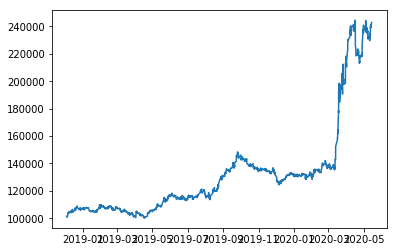

In [43]:
plt.plot(df.money)

In [ ]:
profit_compound = dict()
profit_simple = dict()
for i in tickers:
    try:
        df = BB_strat_backtest(i)
        a1 = ((df['money'].iloc[-1]) - 100000)/1000
        a2 = (sum(df['2'])/df['0'].iloc[0])*100
        profit_simple[i] = a2
        profit_compound[i] = a1
        print(i)
    except:
        pass

In [ ]:
df1 = pd.DataFrame(profit_simple).T
df2 = pd.DataFrame(profit_compound).T
df1.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str('profit_simple') + '_BB.csv')
df2.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str('profit_compound') + '_BB.csv')        

In [ ]:
profit_compound

In [ ]:
profit_simple

In [ ]:
result = pd.DataFrame(index = profit_simple.keys())

In [ ]:
result['simple'] = profit_simple.values()

In [ ]:
result['compound']=  profit_compound.values()

In [ ]:
result.to_csv(r'A:\finance_stuff\50x\attempts\BB\\' + str('result') + '_BB.csv')